# Deep Learning for Time Series Forecasting

## Overview
This notebook demonstrates deep learning techniques for time series forecasting using:
- Synthetic data generation
- Baseline models (Naive, Linear Regression)
- Deep Learning models (MLP, RNN, LSTM, GRU)
- Model comparison and evaluation

**Author**: Generated with Claude Code  
**Date**: 2025

## 1. Setup and Imports

In [1]:
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, SimpleRNN, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

# Configuration
np.random.seed(42)
tf.random.set_seed(42)
sns.set_style('whitegrid')

print(f'TensorFlow version: {tf.__version__}')
print(f'NumPy version: {np.__version__}')
print(f'Pandas version: {pd.__version__}')

TensorFlow version: 2.19.0
NumPy version: 2.0.2
Pandas version: 2.2.2


## 2. Generate Synthetic Time Series Data

We'll create a synthetic time series with:
- **Trend**: Linear increase over time
- **Seasonality**: Periodic pattern (monthly)
- **Noise**: Random fluctuations

In [2]:
YEARS = 30
MONTHS = YEARS * 12  # 360 months
INTERCEPT = 100
SLOPE = 2
AMPLITUDE = 20
PERIOD = 12
NOISE_STD = 5

# Generate time index
date_range = pd.date_range(start='2000-01-01', periods=MONTHS, freq='MS')
t = np.arange(MONTHS)

# Components
trend = INTERCEPT + SLOPE * t
seasonality = AMPLITUDE * np.sin(2 * np.pi * t / PERIOD)
noise = np.random.normal(0, NOISE_STD, MONTHS)

# Combine
values = trend + seasonality + noise

# Create DataFrame
df = pd.DataFrame({
    'date': date_range,
    'value': values,
    'trend': trend,
    'seasonality': seasonality,
    'noise': noise
})
df.set_index('date', inplace=True)

print("Synthetic Time Series Generated")
print(f"Shape: {df.shape}")
print(f"Date range: {df.index.min()} to {df.index.max()}")
print(f"Total months: {len(df)}")
print("\nFirst 5 rows:")
display(df.head())

Synthetic Time Series Generated
Shape: (360, 4)
Date range: 2000-01-01 00:00:00 to 2029-12-01 00:00:00
Total months: 360

First 5 rows:


,value,trend,seasonality,noise
date,,,,
2000-01-01,102.483571,100,0.000000,2.483571
2000-02-01,111.308678,102,10.000000,-0.691322
2000-03-01,124.558951,104,17.320508,3.238443
2000-04-01,133.615149,106,20.000000,7.615149
2000-05-01,124.149741,108,17.320508,-1.170767


### 2.1 Visualize Time Series Components

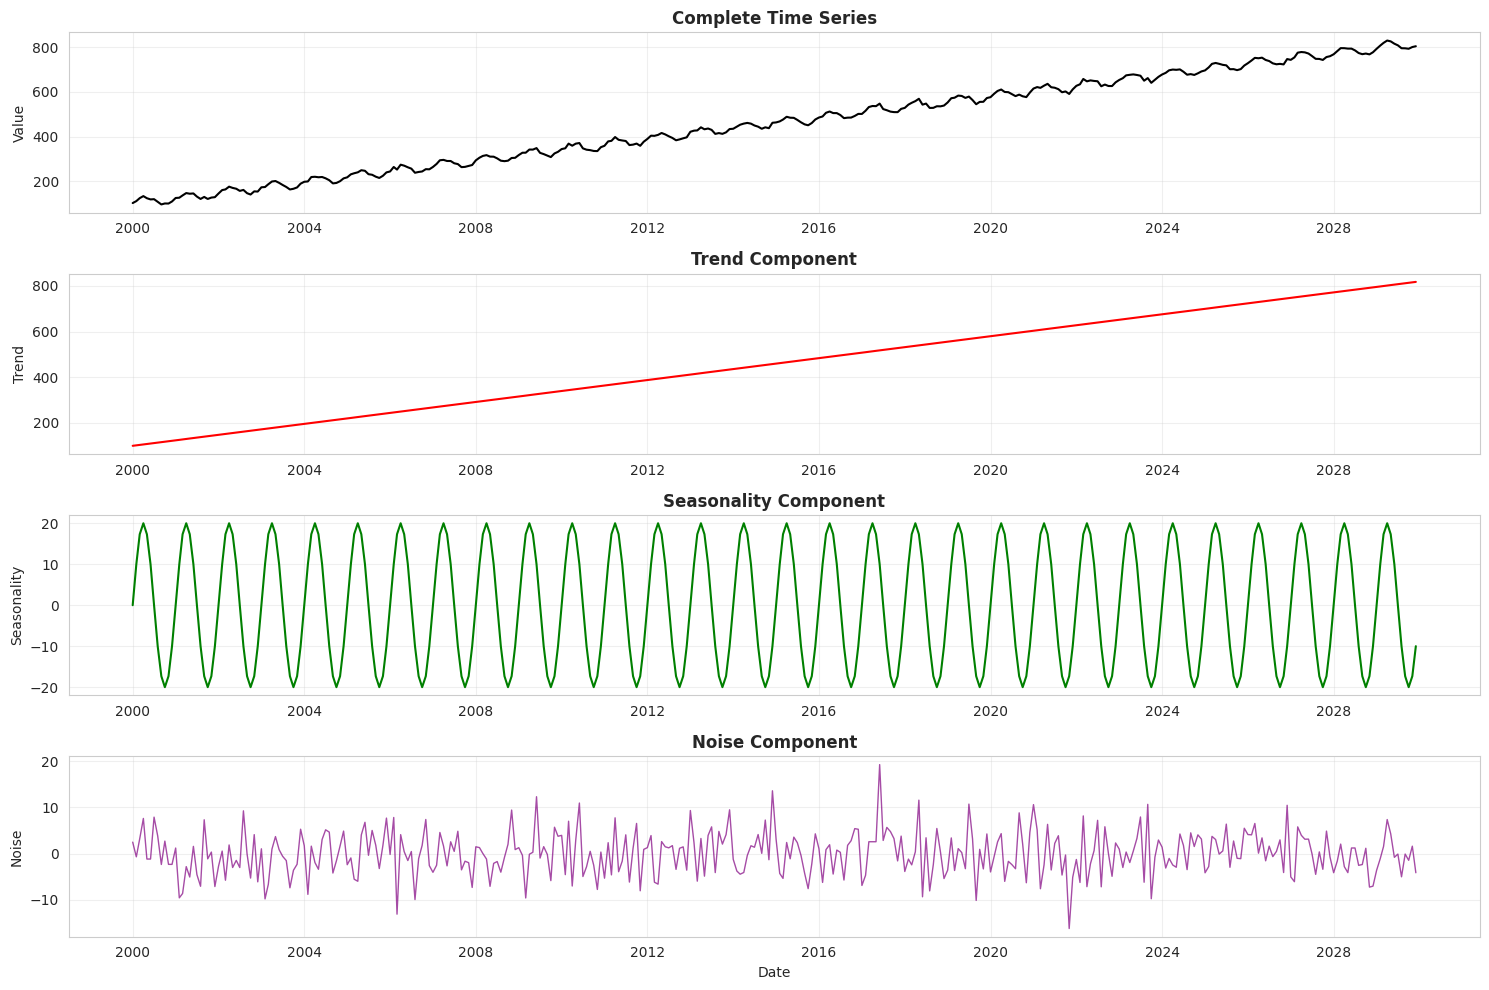

In [3]:
# Visualize components
fig, axes = plt.subplots(4, 1, figsize=(15, 10))

# Full series
axes[0].plot(df.index, df['value'], color='black', linewidth=1.5)
axes[0].set_title('Complete Time Series', fontweight='bold', fontsize=12)
axes[0].set_ylabel('Value')
axes[0].grid(True, alpha=0.3)

# Trend
axes[1].plot(df.index, df['trend'], color='red', linewidth=1.5)
axes[1].set_title('Trend Component', fontweight='bold', fontsize=12)
axes[1].set_ylabel('Trend')
axes[1].grid(True, alpha=0.3)

# Seasonality
axes[2].plot(df.index, df['seasonality'], color='green', linewidth=1.5)
axes[2].set_title('Seasonality Component', fontweight='bold', fontsize=12)
axes[2].set_ylabel('Seasonality')
axes[2].grid(True, alpha=0.3)

# Noise
axes[3].plot(df.index, df['noise'], color='purple', alpha=0.7, linewidth=1)
axes[3].set_title('Noise Component', fontweight='bold', fontsize=12)
axes[3].set_ylabel('Noise')
axes[3].set_xlabel('Date')
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Data Preparation

### 3.1 Train/Validation/Test Split

Data Split:
Train: 216 samples (2000-01-01 00:00:00 to 2017-12-01 00:00:00)
Validation: 72 samples (2018-01-01 00:00:00 to 2023-12-01 00:00:00)
Test: 72 samples (2024-01-01 00:00:00 to 2029-12-01 00:00:00)


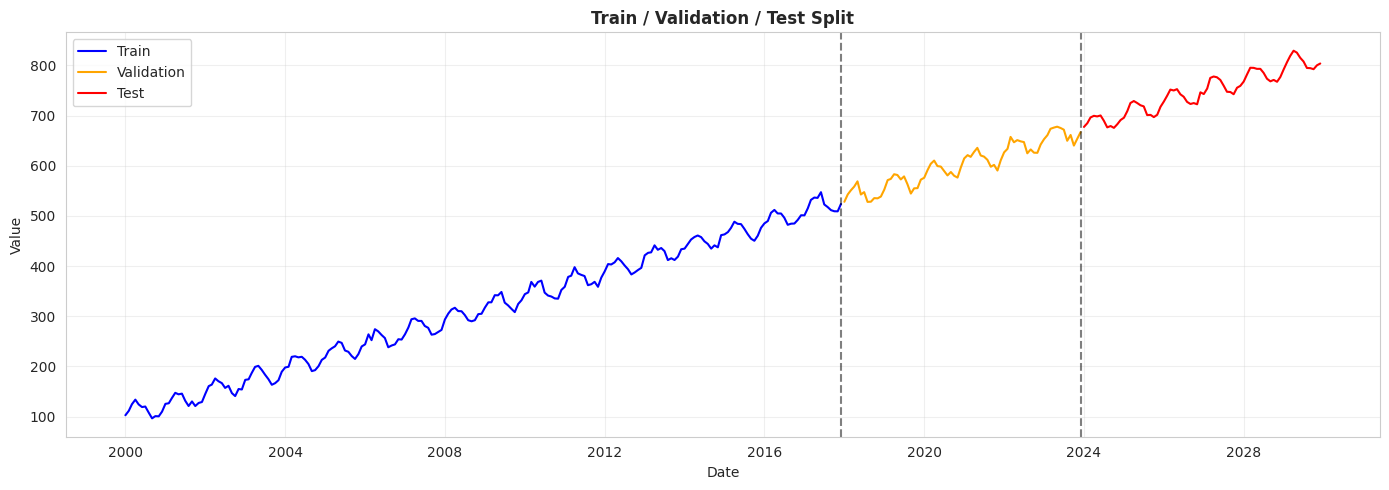


Train data sample:


,value,trend,seasonality,noise
date,,,,
2000-01-01,102.483571,100,0.000000,2.483571
2000-02-01,111.308678,102,10.000000,-0.691322
2000-03-01,124.558951,104,17.320508,3.238443
2000-04-01,133.615149,106,20.000000,7.615149
2000-05-01,124.149741,108,17.320508,-1.170767



Validation data sample:


,value,trend,seasonality,noise
date,,,,
2018-01-01,528.135874,532,-8.817457e-14,-3.864126
2018-02-01,542.815907,534,1.000000e+01,-1.184093
2018-03-01,550.893690,536,1.732051e+01,-2.426818
2018-04-01,558.409371,538,2.000000e+01,0.409371
2018-05-01,568.893801,540,1.732051e+01,11.573293



Test data sample:


,value,trend,seasonality,noise
date,,,,
2024-01-01,677.404959,676,-1.175661e-13,1.404959
2024-02-01,684.886502,678,1.000000e+01,-3.113498
2024-03-01,696.279897,680,1.732051e+01,-1.040611
2024-04-01,699.534995,682,2.000000e+01,-2.465005
2024-05-01,698.373684,684,1.732051e+01,-2.946824


In [28]:
# Split: 60% train, 20% validation, 20% test
n = len(df)
train_size = int(n * 0.6)
val_size = int(n * 0.2)

train_df = df.iloc[:train_size]
val_df = df.iloc[train_size:train_size + val_size]
test_df = df.iloc[train_size + val_size:]

print("Data Split:")
print(f"Train: {len(train_df)} samples ({train_df.index.min()} to {train_df.index.max()})")
print(f"Validation: {len(val_df)} samples ({val_df.index.min()} to {val_df.index.max()})")
print(f"Test: {len(test_df)} samples ({test_df.index.min()} to {test_df.index.max()})")

# Visualize split
plt.figure(figsize=(14, 5))
plt.plot(train_df.index, train_df['value'], label='Train', color='blue')
plt.plot(val_df.index, val_df['value'], label='Validation', color='orange')
plt.plot(test_df.index, test_df['value'], label='Test', color='red')
plt.axvline(train_df.index[-1], color='black', linestyle='--', alpha=0.5)
plt.axvline(val_df.index[-1], color='black', linestyle='--', alpha=0.5)
plt.title('Train / Validation / Test Split', fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nTrain data sample:")
display(train_df.head())
print("\nValidation data sample:")
display(val_df.head())
print("\nTest data sample:")
display(test_df.head())

### 3.2 Windowing Function for Sequence Creation

This function creates input-output pairs for training sequential models.

In [29]:
def create_windows(data, window_size, horizon=1):
    """
    Create windowed dataset for time series forecasting.

    Args:
        data: 1D array or Series
        window_size: Number of past timesteps to use as input
        horizon: Number of future timesteps to predict

    Returns:
        X: Input sequences (n_samples, window_size)
        y: Target values (n_samples, horizon)
    """
    if isinstance(data, pd.Series):
        data = data.values

    X, y = [], []

    for i in range(len(data) - window_size - horizon + 1):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size:i + window_size + horizon])

    return np.array(X), np.array(y)

# Test the function
WINDOW_SIZE = 12  # Use 12 months to predict next
HORIZON = 1       # Predict 1 month ahead

X_train, y_train = create_windows(train_df['value'], WINDOW_SIZE, HORIZON)
X_val, y_val = create_windows(val_df['value'], WINDOW_SIZE, HORIZON)
X_test, y_test = create_windows(test_df['value'], WINDOW_SIZE, HORIZON)

print("Windowed Dataset Created:")
print(f"X_train shape: {X_train.shape} (samples, window_size)")
print(f"y_train shape: {y_train.shape} (samples, horizon)")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}") # Added y_val shape
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}") # Added y_test shape

print(f"\nExample X_train[0]: {X_train[0]}")
print(f"Example y_train[0]: {y_train[0]}")
print(f"\nExample X_val[0]: {X_val[0]}") # Added example for X_val
print(f"Example y_val[0]: {y_val[0]}") # Added example for y_val
print(f"\nExample X_test[0]: {X_test[0]}") # Added example for X_test
print(f"Example y_test[0]: {y_test[0]}") # Added example for y_test

Windowed Dataset Created:
X_train shape: (204, 12) (samples, window_size)
y_train shape: (204, 1) (samples, horizon)
X_val shape: (60, 12)
y_val shape: (60, 1)
X_test shape: (60, 12)
y_test shape: (60, 1)

Example X_train[0]: [102.48357077 111.30867849 124.55895077 133.61514928 124.1497412
 118.82931522 119.89606408 107.83717365  96.33211999 100.71280022
 100.36240346 109.67135123]
Example y_train[0]: [125.20981136]

Example X_val[0]: [528.13587393 542.81590697 550.89369034 558.4093707  568.89380091
 542.66367404 547.43130095 527.93642064 528.3198326  535.44475298
 535.00089202 538.61127611]
Example y_val[0]: [552.42348145]

Example X_test[0]: [677.40495934 684.8865024  696.27989682 699.53499533 698.37368429
 700.24801049 689.78507743 676.53545202 679.1774913  675.5364976
 682.74380252 691.14814421]
Example y_test[0]: [695.85502495]


### 3.3 Normalization

In [30]:
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Fit on training data only
X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

# Also normalize y (targets) - CRITICAL for DL model performance!
y_train_scaled = scaler_y.fit_transform(y_train)
y_val_scaled = scaler_y.transform(y_val)
y_test_scaled = scaler_y.transform(y_test)

# For RNN models, reshape to (samples, timesteps, features)
X_train_rnn = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_val_rnn = X_val_scaled.reshape(X_val_scaled.shape[0], X_val_scaled.shape[1], 1)
X_test_rnn = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

print("Data Normalized:")
print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"y_train_scaled shape: {y_train_scaled.shape} (NOW normalized)")
print(f"X_val_scaled shape: {X_val_scaled.shape}") # Added val scaled shapes
print(f"y_val_scaled shape: {y_val_scaled.shape}") # Added val scaled shapes
print(f"X_test_scaled shape: {X_test_scaled.shape}") # Added test scaled shapes
print(f"y_test_scaled shape: {y_test_scaled.shape}") # Added test scaled shapes
print(f"X_train_rnn shape: {X_train_rnn.shape} (for RNN/LSTM/GRU)")
print(f"X_val_rnn shape: {X_val_rnn.shape}") # Added val rnn shape
print(f"X_test_rnn shape: {X_test_rnn.shape}") # Added test rnn shape

print(f"\nScaler X statistics (fitted on training data):")
print(f"Mean: {scaler_X.mean_[:5]}...")  # Show first 5
print(f"Std: {scaler_X.scale_[:5]}...")   # Show first 5
print(f"\nScaler y statistics:")
print(f"Mean: {scaler_y.mean_}")
print(f"Std: {scaler_y.scale_}")
print(f"\nNote: Predictions will be inverse transformed back to original scale")

print("\nExample X_train_scaled[0]:", X_train_scaled[0]) # Added scaled examples
print("Example y_train_scaled[0]:", y_train_scaled[0])
print("\nExample X_train_rnn[0]:", X_train_rnn[0]) # Added rnn example

Data Normalized:
X_train_scaled shape: (204, 12)
y_train_scaled shape: (204, 1) (NOW normalized)
X_val_scaled shape: (60, 12)
y_val_scaled shape: (60, 1)
X_test_scaled shape: (60, 12)
y_test_scaled shape: (60, 1)
X_train_rnn shape: (204, 12, 1) (for RNN/LSTM/GRU)
X_val_rnn shape: (60, 12, 1)
X_test_rnn shape: (60, 12, 1)

Scaler X statistics (fitted on training data):
Mean: [302.8750302  304.82908943 306.80949235 308.80624104 310.78150467]...
Std: [118.47364082 118.43975069 118.56493117 118.90831731 119.32782166]...

Scaler y statistics:
Mean: [326.9555496]
Std: [118.94190241]

Note: Predictions will be inverse transformed back to original scale

Example X_train_scaled[0]: [-1.69144341 -1.63391437 -1.53713699 -1.47332916 -1.56402556 -1.62134192
 -1.62540796 -1.74107571 -1.85495898 -1.8395754  -1.86364896 -1.8073559 ]
Example y_train_scaled[0]: [-1.69617043]

Example X_train_rnn[0]: [[-1.69144341]
 [-1.63391437]
 [-1.53713699]
 [-1.47332916]
 [-1.56402556]
 [-1.62134192]
 [-1.62540796]


## 4. Baseline Models

### 4.1 Naive (Persistence) Model

In [8]:
# Naive forecast: predict last value in window
y_pred_naive = X_test[:, -1].reshape(-1, 1)

# Calculate metrics
mae_naive = mean_absolute_error(y_test, y_pred_naive)
rmse_naive = np.sqrt(mean_squared_error(y_test, y_pred_naive))

print("="*60)
print("NAIVE (PERSISTENCE) MODEL")
print("="*60)
print(f"MAE:  {mae_naive:.4f}")
print(f"RMSE: {rmse_naive:.4f}")
print("="*60)

NAIVE (PERSISTENCE) MODEL
MAE:  7.6312
RMSE: 9.4516


### 4.2 Linear Regression Model

In [9]:
# Train linear regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict
y_pred_lr = lr_model.predict(X_test)

# Metrics
mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))

print("="*60)
print("LINEAR REGRESSION MODEL")
print("="*60)
print(f"MAE:  {mae_lr:.4f}")
print(f"RMSE: {rmse_lr:.4f}")
print("="*60)

LINEAR REGRESSION MODEL
MAE:  3.5823
RMSE: 4.3674


## 5. Deep Learning Models

### 5.1 MLP (Multi-Layer Perceptron)

In [24]:
# Build MLP model - Keep architecture same but train on normalized data
mlp_model = Sequential([
    Dense(128, activation='relu', input_shape=(WINDOW_SIZE,)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(HORIZON)
])

mlp_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

print("MLP Model Architecture:")
mlp_model.summary()

# Callbacks
early_stopping_mlp = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Train on NORMALIZED data
print("\nTraining MLP...")
history_mlp = mlp_model.fit(
    X_train_scaled, y_train_scaled,  # Use scaled y!
    validation_data=(X_val_scaled, y_val_scaled),
    epochs=100,
    batch_size=16,
    verbose=0,
    callbacks=[early_stopping_mlp]
)

# Predict (in normalized space)
y_pred_mlp_scaled = mlp_model.predict(X_test_scaled, verbose=0)

# INVERSE TRANSFORM to get predictions in original scale
y_pred_mlp = scaler_y.inverse_transform(y_pred_mlp_scaled)

# Evaluate on original scale
mae_mlp = mean_absolute_error(y_test, y_pred_mlp)
rmse_mlp = np.sqrt(mean_squared_error(y_test, y_pred_mlp))

print("="*60)
print("MLP MODEL")
print("="*60)
print(f"MAE:  {mae_mlp:.4f}")
print(f"RMSE: {rmse_mlp:.4f}")
print(f"Epochs trained: {len(history_mlp.history['loss'])}")
print("="*60)

MLP Model Architecture:


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_30 (Dense)                │ (None, 128)            │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,033 (47.00 KB)

 Trainable params: 12,033 (47.00 KB)

 Non-trainable params: 0 (0.00 B)


Training MLP...
Epoch 15: early stopping
Restoring model weights from the end of the best epoch: 5.
MLP MODEL
MAE:  23.9129
RMSE: 26.0976
Epochs trained: 15


### 5.2 RNN (Simple Recurrent Neural Network)

### 5.3 LSTM (Long Short-Term Memory)

In [31]:
# Build LSTM model - Improved architecture with more layers/units
lstm_model = Sequential([
    LSTM(128, activation='tanh', return_sequences=True, input_shape=(WINDOW_SIZE, 1)),
    Dropout(0.3),
    LSTM(64, activation='tanh', return_sequences=True),
    Dropout(0.3),
    LSTM(32, activation='tanh', return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(HORIZON)
])

lstm_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

print("LSTM Model Architecture:")
lstm_model.summary()

# Callbacks
early_stopping_lstm = EarlyStopping(
    monitor='val_loss',
    patience=30,
    restore_best_weights=True,
    verbose=1
)

# Add Learning Rate Scheduler
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=0.0001,
    verbose=1
)


# Train
print("\\nTraining LSTM...")
print(f"Shape of X_train_rnn: {X_train_rnn.shape}")
print(f"Shape of y_train_scaled: {y_train_scaled.shape}")
print(f"Shape of X_val_rnn: {X_val_rnn.shape}")
print(f"Shape of y_val_scaled: {y_val_scaled.shape}")
history_lstm = lstm_model.fit(
    X_train_rnn, y_train_scaled, # Use scaled y!
    validation_data=(X_val_rnn, y_val_scaled), # Use scaled y!
    epochs=200,
    batch_size=16,
    verbose=0,
    callbacks=[early_stopping_lstm, reduce_lr] # Add reduce_lr callback
)

# Predict (in normalized space)
y_pred_lstm_scaled = lstm_model.predict(X_test_rnn, verbose=0)

# INVERSE TRANSFORM to get predictions in original scale
y_pred_lstm = scaler_y.inverse_transform(y_pred_lstm_scaled)

# Evaluate on original scale
mae_lstm = mean_absolute_error(y_test, y_pred_lstm)
rmse_lstm = np.sqrt(mean_squared_error(y_test, y_pred_lstm))

print("="*60)
print("LSTM MODEL")
print("="*60)
print(f"MAE:  {mae_lstm:.4f}")
print(f"RMSE: {rmse_lstm:.4f}")
print(f"Epochs trained: {len(history_lstm.history['loss'])}")
print("="*60)

LSTM Model Architecture:


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_19 (LSTM)                  │ (None, 12, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_47 (Dropout)            │ (None, 12, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_20 (LSTM)                  │ (None, 12, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_48 (Dropout)            │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_21 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_49 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 129,473 (505.75 KB)

 Trainable params: 129,473 (505.75 KB)

 Non-trainable params: 0 (0.00 B)

\nTraining LSTM...
Shape of X_train_rnn: (204, 12, 1)
Shape of y_train_scaled: (204, 1)
Shape of X_val_rnn: (60, 12, 1)
Shape of y_val_scaled: (60, 1)

Epoch 15: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 20: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 25: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 30: ReduceLROnPlateau reducing learning rate to 0.0001.
Epoch 40: early stopping
Restoring model weights from the end of the best epoch: 10.
LSTM MODEL
MAE:  158.2328
RMSE: 161.3759
Epochs trained: 40
